# Determining the age of customers

The chain supermarket "Bread-Salt" introduces a computer vision system for processing customer photos.

Photo fixation in the checkout area will help determine the age of customers in order to:

- Analyze purchases and offer products that may be of interest to buyers of this age group;
- Monitor the integrity of cashiers when selling alcohol.


Build a model that can determine the approximate age of a person from a photo. At our disposal is a set of photos of people with age indication.

## EDA

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
# data loading and scaling
data = pd.read_csv('/datasets/faces/labels.csv')

datagen = ImageDataGenerator(rescale=1./255,validation_split=0.25)

train_datagen_flow = datagen.flow_from_dataframe(
        dataframe=data,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

val_datagen_flow = datagen.flow_from_dataframe(
        dataframe=data,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345) 

Found 5694 validated image filenames.
Found 1897 validated image filenames.


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
data.head(5)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [5]:
data.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


There is an average score of 1000 images per class for the classification task. We are solving a regression problem we need to get mae less than 8. We can imagine a similar classification problem for 15 classes which gives a similar accuracy. In this case, we need 15000 images which is twice as many as we have. But the good news is that twice is not ten and besides we can use reflections so according to a preliminary estimate the data should be enough.

- Most of the data belongs to people aged 20-25;
- there are several peaks at 20, 40, 50, 60 and 80 years;
- a lot of data that is labeled from 0 to 5 years.
    
we can drop these zeros since they don't really have a positive effect on our results. It is unlikely that buyers will be of this age.

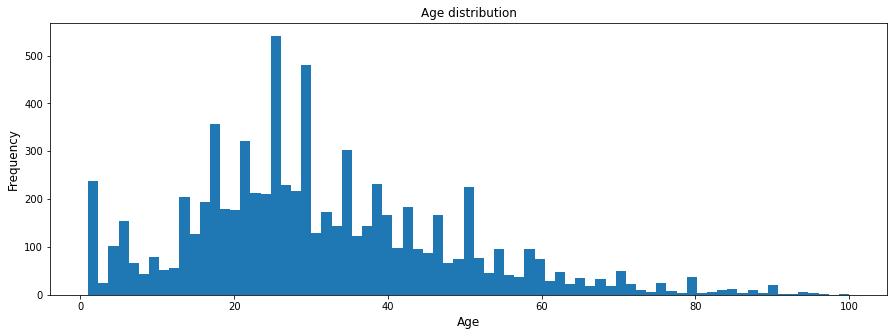

In [6]:
# Plot a histogram of age distribution
plt.figure(figsize=(15,5))
plt.hist(data.real_age, bins=75)
plt.title("Age distribution")
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Age', fontsize=12)
plt.show()

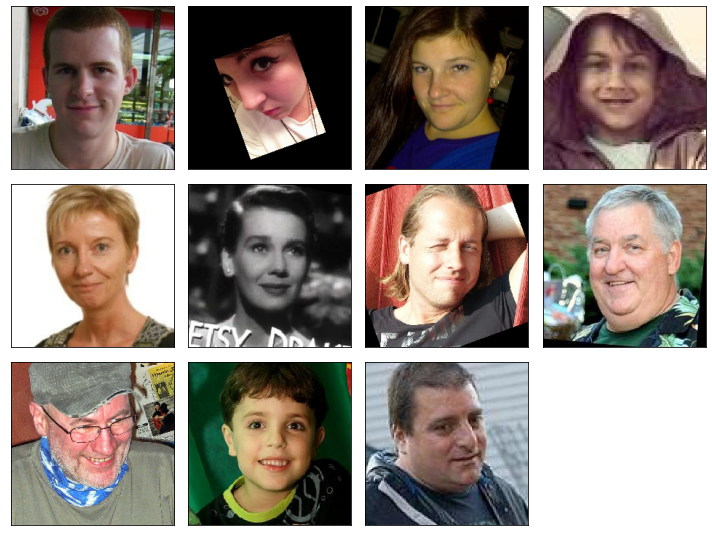

In [7]:
# Output 10 photos on the screen
features, target = next(train_datagen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(11):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

- difficulty in predicting due to clothing and facial hair attributes
- tilting the photo can introduce complexity
- contrast and brightness can introduce some uncertainty

the model will be poor at predicting the age of older people and will mostly predict an age of ~30 years.

I'll try to put forward a hypothesis why some of the photos are rotated. You need to understand how the dataset was going. As far as I understand at first a lot of different photos were collected from the Internet (this also explains the presence of black-and-white photos, frames from films and photos of celebrities in the sample).
    
Then, using computer vision algorithms the following operations were performed:
    
   - Defined faces and cut out from the photo
   - The angle of deviation of the face from the vertical was found and an attempt was made to align.
    
If you take a closer look at the data, you can find places where the algorithm "missed" in the search for a face. But this is a rarity. Mistakes with turns are much more common according to my observations on low-quality photos or where extraneous objects interfered with the algorithm - glasses, chewing gum, etc.

## Train model

```python
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd


def load_train(path):

    df = pd.read_csv(path+'/labels.csv')

    train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        validation_split=0.2)

    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=df,
        directory= path + 'final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):

    df = pd.read_csv(path+'/labels.csv')

    valid_datagen = ImageDataGenerator(
        rescale=1. / 255, 
        validation_split=0.2)

    validation_gen_flow = valid_datagen.flow_from_dataframe(
        dataframe=df,
        directory= path + 'final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return validation_gen_flow

def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.00001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model
```
ghghjg

Functions were written for creating data generators as well as creating and training a model.

```

Train for 190 steps, validate for 48 steps
Epoch 1/10
190/190 - 57s - loss: 716.6920 - mae: 21.9904 - val_loss: 1098.1007 - val_mae: 28.4685
Epoch 2/10
190/190 - 44s - loss: 167.2793 - mae: 9.7501 - val_loss: 1068.1957 - val_mae: 27.9572
Epoch 3/10
190/190 - 45s - loss: 73.0216 - mae: 6.4081 - val_loss: 962.5719 - val_mae: 26.2853
Epoch 4/10
190/190 - 43s - loss: 38.4879 - mae: 4.7107 - val_loss: 201.9544 - val_mae: 10.4066
Epoch 5/10
190/190 - 41s - loss: 23.9680 - mae: 3.7161 - val_loss: 114.2725 - val_mae: 8.1641
Epoch 6/10
190/190 - 47s - loss: 18.3444 - mae: 3.2236 - val_loss: 92.8620 - val_mae: 7.1612
Epoch 7/10
190/190 - 47s - loss: 16.1837 - mae: 3.0119 - val_loss: 88.6809 - val_mae: 7.0683
Epoch 8/10
190/190 - 47s - loss: 14.0760 - mae: 2.8616 - val_loss: 85.7542 - val_mae: 6.9907
Epoch 9/10
190/190 - 46s - loss: 12.5118 - mae: 2.7381 - val_loss: 84.7686 - val_mae: 6.9465
Epoch 10/10
190/190 - 46s - loss: 11.7559 - mae: 2.6562 - val_loss: 84.3340 - val_mae: 6.9517

```

The model is trained and overcame the bar of the required accuracy

## Model analysis

ResNet50 trained. Metric MAE 6.9 which is a good result.

- 10 epochs;
- Adam optimizer;
- freezing of the backbone weights was not used;
- The model did not retrain as the loss and mae decrease on both the training and validation sets.